In [ ]:
%%capture
!pip install numpy
!pip install pandas
!pip install requests
!pip install pandas_datareader
!pip install yfinance
!pip install math
!pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm

# package to download data, from pandas 
import pandas_datareader as web

# packages to work with time and dates

import datetime as dt
import matplotlib.dates as mdates
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Attempting to replicate the paper results (2019-01-01 to 2019-07-17)

In [ ]:
start = pd.to_datetime(['2019-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2019-07-17']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'BTC-USD' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

S=df.Close.tolist()

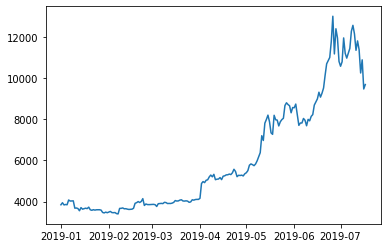

In [ ]:
plt.plot(pd.to_datetime(df.Date), df.Close)

plt.show()

In [ ]:
df.Close.describe()

count      198.000000
mean      6042.811293
std       2706.394802
min       3399.471680
25%       3860.791565
50%       5093.062745
75%       7998.851196
max      13016.231445
Name: Close, dtype: float64

In [ ]:
X = list(range(3300, 8000, 300))
print(len(X))
X

16


[3300,
 3600,
 3900,
 4200,
 4500,
 4800,
 5100,
 5400,
 5700,
 6000,
 6300,
 6600,
 6900,
 7200,
 7500,
 7800]

In [ ]:
def volatilityEstimator(X): # X is a list of price samples
    h = 500
    numerator = 0
    sigma = []
    counter = 0
    n = len(S)
    
    for x in X: 
        for i in range(len(S)-1):
            if((abs(S[i] - x)) < (h)):
                numerator += n*((S[i+1]-S[i])**2)
                counter +=1
        if (numerator != 0):
            sigma.append(np.sqrt(numerator/counter))
        if (numerator == 0):
            sigma.append(np.nan)
        numerator = 0
        counter = 0
    return sigma

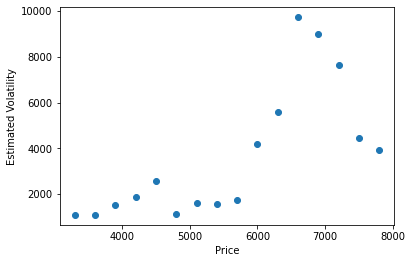

In [ ]:
fig,ax = plt.subplots(1)

# plot the data
ax.scatter(X, volatilityEstimator(X))
ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")

plt.show()

In [ ]:
pairs = [(X[i], volatilityEstimator(X)[i]) for i in range(len(X))]

In [ ]:
def theta(i, j): # i and j are indicies of the `pairs` list
    sigdiff = (pairs[i][1] - pairs[j][1])
    sdiff = (pairs[i][0] - pairs[j][0])
    return math.degrees(math.atan(sigdiff/sdiff))

# lower convex hull
i = 0
lch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = min(angles, key=angles.get)
    lch.append(pairs[i])

# upper convex hull
i = 0
uch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = max(angles, key=angles.get)
    uch.append(pairs[i])

In [ ]:
# interpolate the convex hulls (linear interpolation)
lch_interpolated = pd.Series({x[0]: x[1] for x in lch}, index=X, name='lch').interpolate()
uch_interpolated = pd.Series({x[0]: x[1] for x in uch}, index=X, name='uch').interpolate()

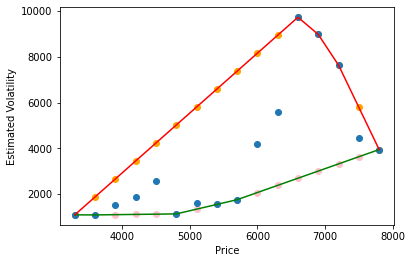

In [ ]:
fig,ax = plt.subplots(1)

# convex hulls
ax.plot([x[0] for x in lch], [x[1] for x in lch], color = 'green')
ax.plot([x[0] for x in uch], [x[1] for x in uch], color = 'red')

# interpolated points
ax.scatter(X, lch_interpolated, color='pink')
ax.scatter(X, uch_interpolated, color='orange')

# point estimates 
ax.scatter(X, volatilityEstimator(X))

ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")

plt.show()

In [ ]:
# transform variables for OLS
hull = pd.concat([lch_interpolated, uch_interpolated], axis=1).reset_index().rename(columns={'index': 'price'})
hull['log_lch'] = np.log(hull.lch)
hull['log_uch'] = np.log(hull.uch)
hull['log_price'] = np.log(hull.price)
hull.head()

,price,lch,uch,log_lch,log_uch,log_price
0,3300,1098.623172,1098.623172,7.001813,7.001813,8.101678
1,3600,1095.698654,1883.089083,6.999147,7.540669,8.188689
2,3900,1106.683841,2667.554995,7.009123,7.888918,8.268732
3,4200,1117.669027,3452.020907,7.019001,8.146715,8.342840
4,4500,1128.654213,4236.486819,7.028781,8.351490,8.411833


In [ ]:
# Hypothesis testing

#upper bound on integral
Y1 = hull.log_lch
X1 = hull.log_price
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y1,X1)

results1 = model1.fit()

if (results1.params['log_price'] > 1 + 1.645*results1.bse['log_price']):
    # reject the null hypothesis of "No bubble"
    print("Test ends. There is a bubble.")
else: 
    print("Upper bound inconclusive--testing lower bound.")
    #lower bound on integral
    Y2 = hull.log_uch
    X2 = hull.log_price
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(Y2,X2)

    results2 = model2.fit()
    
    if (results2.params['log_price'] <= 1 - 1.645*results2.bse['log_price']):
        # reject the null hypothesis of "There is a bubble"
        print("Test ends. There is no bubble.")
    else: 
        print("Test inconclusive.")

Test ends. There is a bubble.


---

# 2021-07-18 to 2022-01-28

In [ ]:
start = pd.to_datetime(['2021-07-18']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-01-28']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'BTC-USD' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

S=df.Close.tolist()

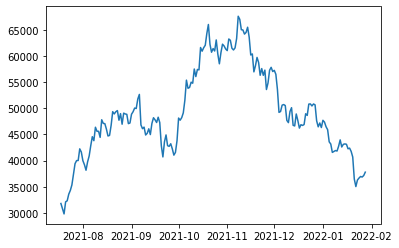

In [ ]:
plt.plot(pd.to_datetime(df.Date), df.Close)

plt.show()

In [ ]:
X = list(range(32000, 66000, 2000))
print(len(X))
X

17


[32000,
 34000,
 36000,
 38000,
 40000,
 42000,
 44000,
 46000,
 48000,
 50000,
 52000,
 54000,
 56000,
 58000,
 60000,
 62000,
 64000]

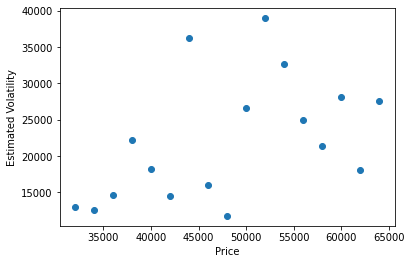

In [ ]:
fig,ax = plt.subplots(1)

# plot the data
ax.scatter(X, volatilityEstimator(X))
ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")
plt.show()

In [ ]:
pairs = [(X[i], volatilityEstimator(X)[i]) for i in range(len(X))]

In [ ]:
# lower convex hull
i = 0
lch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = min(angles, key=angles.get)
    lch.append(pairs[i])

# upper convex hull
i = 0
uch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = max(angles, key=angles.get)
    uch.append(pairs[i])

In [ ]:
# interpolate the convex hulls (linear interpolation)
lch_interpolated = pd.Series({x[0]: x[1] for x in lch}, index=X, name='lch').interpolate()
uch_interpolated = pd.Series({x[0]: x[1] for x in uch}, index=X, name='uch').interpolate()

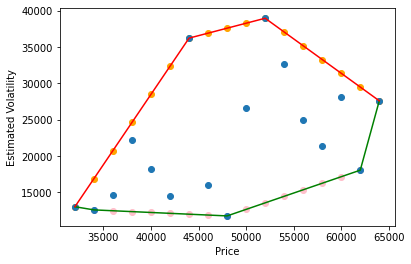

In [ ]:
fig,ax = plt.subplots(1)

# convex hulls
ax.plot([x[0] for x in lch], [x[1] for x in lch], color = 'green')
ax.plot([x[0] for x in uch], [x[1] for x in uch], color = 'red')

# interpolated points
ax.scatter(X, lch_interpolated, color='pink')
ax.scatter(X, uch_interpolated, color='orange')

# point estimates 
ax.scatter(X, volatilityEstimator(X))

ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")

plt.show()

In [ ]:
# transform variables for OLS
hull = pd.concat([lch_interpolated, uch_interpolated], axis=1).reset_index().rename(columns={'index': 'price'})
hull['log_lch'] = np.log(hull.lch)
hull['log_uch'] = np.log(hull.uch)
hull['log_price'] = np.log(hull.price)
hull.head()

,price,lch,uch,log_lch,log_uch,log_price
0,32000,13020.791141,13020.791141,9.474303,9.474303,10.373491
1,34000,12584.056701,16888.570536,9.440186,9.734392,10.434116
2,36000,12465.639507,20756.349931,9.430731,9.940607,10.491274
3,38000,12347.222314,24624.129326,9.421186,10.111482,10.545341
4,40000,12228.805120,28491.908721,9.411550,10.257375,10.596635


In [ ]:
# Hypothesis testing

#upper bound on integral
Y1 = hull.log_lch
X1 = hull.log_price
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y1,X1)

results1 = model1.fit()

if (results1.params['log_price'] > 1 + 1.645*results1.bse['log_price']):
    # reject the null hypothesis of "No bubble"
    print("Test ends. There is a bubble.")
else: 
    print("Upper bound inconclusive--testing lower bound.")
    #lower bound on integral
    Y2 = hull.log_uch
    X2 = hull.log_price
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(Y2,X2)

    results2 = model2.fit()
    
    if (results2.params['log_price'] <= 1 - 1.645*results2.bse['log_price']):
        # reject the null hypothesis of "There is a bubble"
        print("Test ends. There is no bubble.")
    else: 
        print("Test inconclusive.")

Upper bound inconclusive--testing lower bound.
Test inconclusive.


# 2020-03-18 to 2021-06-01

In [ ]:
start = pd.to_datetime(['2020-03-18']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2021-06-01']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'BTC-USD' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

S=df.Close.tolist()

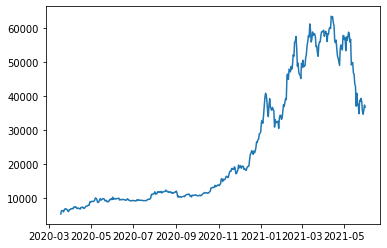

In [ ]:
plt.plot(pd.to_datetime(df.Date), df.Close)
plt.show()

In [ ]:
df.Close.describe()

count      441.000000
mean     24207.931138
std      18459.797960
min       5238.438477
25%       9593.896484
50%      13031.173828
75%      38402.222656
max      63503.457031
Name: Close, dtype: float64

In [ ]:
X = list(range(5200, 63000, 3500))
print(len(X))
X

17


[5200,
 8700,
 12200,
 15700,
 19200,
 22700,
 26200,
 29700,
 33200,
 36700,
 40200,
 43700,
 47200,
 50700,
 54200,
 57700,
 61200]

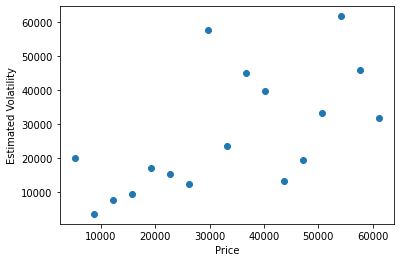

In [ ]:
fig,ax = plt.subplots(1)

# plot the data
ax.scatter(X, volatilityEstimator(X))
ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")
plt.show()

In [ ]:
pairs = [(X[i], volatilityEstimator(X)[i]) for i in range(len(X))]

In [ ]:
# lower convex hull
i = 0
lch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = min(angles, key=angles.get)
    lch.append(pairs[i])

# upper convex hull
i = 0
uch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = max(angles, key=angles.get)
    uch.append(pairs[i])

In [ ]:
# interpolate the convex hulls (linear interpolation)
lch_interpolated = pd.Series({x[0]: x[1] for x in lch}, index=X, name='lch').interpolate()
uch_interpolated = pd.Series({x[0]: x[1] for x in uch}, index=X, name='uch').interpolate()

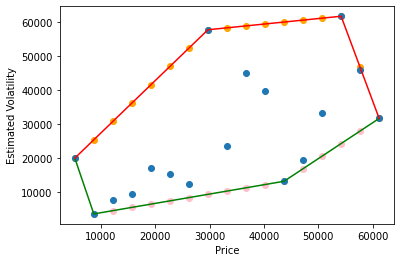

In [ ]:
fig,ax = plt.subplots(1)

# convex hulls
ax.plot([x[0] for x in lch], [x[1] for x in lch], color = 'green')
ax.plot([x[0] for x in uch], [x[1] for x in uch], color = 'red')

# interpolated points
ax.scatter(X, lch_interpolated, color='pink')
ax.scatter(X, uch_interpolated, color='orange')

# point estimates 
ax.scatter(X, volatilityEstimator(X))

ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")

plt.show()

In [ ]:
# transform variables for OLS
hull = pd.concat([lch_interpolated, uch_interpolated], axis=1).reset_index().rename(columns={'index': 'price'})
hull['log_lch'] = np.log(hull.lch)
hull['log_uch'] = np.log(hull.uch)
hull['log_price'] = np.log(hull.price)
hull.head()

,price,lch,uch,log_lch,log_uch,log_price
0,5200,20007.842274,20007.842274,9.903880,9.903880,8.556414
1,8700,3576.793948,25408.924794,8.182222,10.142856,9.071078
2,12200,4538.144241,30810.007314,8.420273,10.335595,9.409191
3,15700,5499.494533,36211.089834,8.612411,10.497121,9.661416
4,19200,6460.844826,41612.172354,8.773515,10.636148,9.862666


In [ ]:
# Hypothesis testing

#upper bound on integral
Y1 = hull.log_lch
X1 = hull.log_price
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y1,X1)

results1 = model1.fit()

if (results1.params['log_price'] > 1 + 1.645*results1.bse['log_price']):
    # reject the null hypothesis of "No bubble"
    print("Test ends. There is a bubble.")
else: 
    print("Upper bound inconclusive--testing lower bound.")
    #lower bound on integral
    Y2 = hull.log_uch
    X2 = hull.log_price
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(Y2,X2)

    results2 = model2.fit()
    
    if (results2.params['log_price'] <= 1 - 1.645*results2.bse['log_price']):
        # reject the null hypothesis of "There is a bubble"
        print("Test ends. There is no bubble.")
    else: 
        print("Test inconclusive.")

Upper bound inconclusive--testing lower bound.
Test ends. There is no bubble.


# Testing a longer time frame: 2019 to present

In [ ]:
start = pd.to_datetime(['2019-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-10-01']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'BTC-USD' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

S=df.Close.tolist()

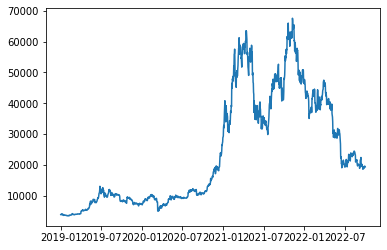

In [ ]:
plt.plot(pd.to_datetime(df.Date), df.Close)

plt.show()

In [ ]:
df.Close.describe()

count     1370.000000
mean     23891.389202
std      18067.330580
min       3399.471680
25%       8876.619629
50%      16516.959961
75%      39513.109375
max      67566.828125
Name: Close, dtype: float64

In [ ]:
X = list(range(18000, 63000, 2900))
print(len(X))
X

16


[18000,
 20900,
 23800,
 26700,
 29600,
 32500,
 35400,
 38300,
 41200,
 44100,
 47000,
 49900,
 52800,
 55700,
 58600,
 61500]

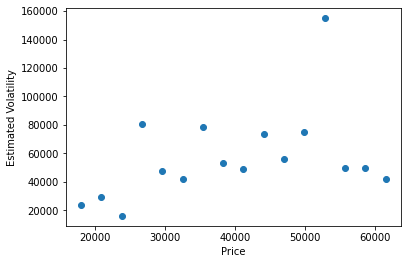

In [ ]:
fig,ax = plt.subplots(1)

# plot the data
ax.scatter(X, volatilityEstimator(X))
ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")
plt.show()

In [ ]:
pairs = [(X[i], volatilityEstimator(X)[i]) for i in range(len(X))]

In [ ]:
# lower convex hull
i = 0
lch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = min(angles, key=angles.get)
    lch.append(pairs[i])

# upper convex hull
i = 0
uch = [pairs[i]]
while (i < len(X) -1):
    angles = {x:theta(x, i) for x in range(len(pairs)) if x>i}
    i = max(angles, key=angles.get)
    uch.append(pairs[i])

In [ ]:
# interpolate the convex hulls (linear interpolation)
lch_interpolated = pd.Series({x[0]: x[1] for x in lch}, index=X, name='lch').interpolate()
uch_interpolated = pd.Series({x[0]: x[1] for x in uch}, index=X, name='uch').interpolate()

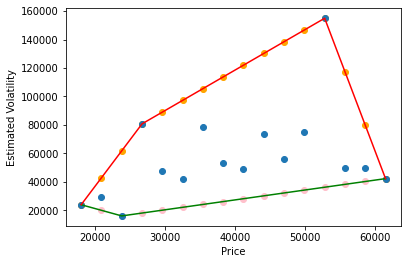

In [ ]:
fig,ax = plt.subplots(1)

# convex hulls
ax.plot([x[0] for x in lch], [x[1] for x in lch], color = 'green')
ax.plot([x[0] for x in uch], [x[1] for x in uch], color = 'red')

# interpolated points
ax.scatter(X, lch_interpolated, color='pink')
ax.scatter(X, uch_interpolated, color='orange')

# point estimates 
ax.scatter(X, volatilityEstimator(X))

ax.set_xlabel("Price")
ax.set_ylabel("Estimated Volatility")

plt.show()

In [ ]:
# transform variables for OLS
hull = pd.concat([lch_interpolated, uch_interpolated], axis=1).reset_index().rename(columns={'index': 'price'})
hull['log_lch'] = np.log(hull.lch)
hull['log_uch'] = np.log(hull.uch)
hull['log_price'] = np.log(hull.price)
hull.head()

,price,lch,uch,log_lch,log_uch,log_price
0,18000,23945.750615,23945.750615,10.083546,10.083546,9.798127
1,20900,20016.373077,42883.401180,9.904306,10.666240,9.947504
2,23800,16086.995538,61821.051744,9.685766,11.031999,10.077441
3,26700,18101.957364,80758.702309,9.803775,11.299221,10.192419
4,29600,20116.919189,89000.993949,9.909316,11.396403,10.295530


In [ ]:
# Hypothesis testing

#upper bound on integral
Y1 = hull.log_lch
X1 = hull.log_price
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y1,X1)

results1 = model1.fit()

if (results1.params['log_price'] > 1 + 1.645*results1.bse['log_price']):
    # reject the null hypothesis of "No bubble"
    print("Test ends. There is a bubble.")
else: 
    print("Upper bound inconclusive--testing lower bound.")
    #lower bound on integral
    Y2 = hull.log_uch
    X2 = hull.log_price
    X2 = sm.add_constant(X2)
    model2 = sm.OLS(Y2,X2)

    results2 = model2.fit()
    
    if (results2.params['log_price'] <= 1 - 1.645*results2.bse['log_price']):
        # reject the null hypothesis of "There is a bubble"
        print("Test ends. There is no bubble.")
    else: 
        print("Test inconclusive.")

Upper bound inconclusive--testing lower bound.
Test inconclusive.
